#Regression


###1.Choosing a Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/CourseworkDataset/RegressionTrain.csv")
# Suitability Assessment
print("\n=== Data Suitability ===")

print(f"Missing Values (Arrival Delay): {df['Arrival Delay in Minutes'].isnull().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Target Variable Skewness: {df['Arrival Delay in Minutes'].skew():.2f}")



=== Data Suitability ===
Missing Values (Arrival Delay): 310
Duplicates: 0
Target Variable Skewness: 6.60


# **Dataset Metadata**

# (a) When and by whom was the dataset created?
 Created by: TJ Klein (Kaggle contributor, 2020)

# (b) How did you access the dataset?
Accessed from: Kaggle (https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction)

# (c) How does it align with the chosen UNSDG?
SDG 9: Industry, Innovation, and Infrastructure

Relevance: Improving service quality in airlines supports sustainable and efficient transport infrastructure through better customer retention.

# (d) List all the attributes (columns) present in the dataset.

In [4]:
print("\n(d) Attributes:", list(df.columns))


(d) Attributes: ['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


In [5]:
df.dtypes

,0
Unnamed: 0,int64
id,int64
Gender,object
Customer Type,object
Age,int64
Type of Travel,object
Class,object
Flight Distance,int64
Inflight wifi service,int64
Departure/Arrival time convenient,int64


# Identify Potential Questions for Analysis

1. How do operational factors (e.g., departure delay, flight distance) affect arrival
delay times?
2. Can we predict arrival delay duration (in minutes) using flight operational data?
3. Does the scheduled departure time (morning, afternoon, night) influence arrival
delays?


###2. Exploratory Data Analysis(EDA)

In [6]:
# =====================================
# Data Cleaning
# =====================================

df_clean = df.copy()

median_delay = df_clean['Arrival Delay in Minutes'].median()
df_clean['Arrival Delay in Minutes'] = df_clean['Arrival Delay in Minutes'].fillna(median_delay)

numerical_features = df_clean.select_dtypes(include=np.number).columns.tolist()
if 'Arrival Delay in Minutes' in numerical_features:
    numerical_features.remove('Arrival Delay in Minutes')
if 'Unnamed: 0' in numerical_features:
    numerical_features.remove('Unnamed: 0')
if 'id' in numerical_features:
    numerical_features.remove('id')

for col in numerical_features:
    if df_clean[col].isnull().any():
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"Imputed missing values in column '{col}' using median.")

df_clean = df_clean.drop(columns=['satisfaction', 'id'], errors='ignore')

categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=False)

scaler = StandardScaler()
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])

print("\n=== Final Data Check ===")
print("Missing Values (Target):", df_clean['Arrival Delay in Minutes'].isna().sum())
print("Feature Shape:", df_clean.shape)

print("\n=== Missing Values in All Columns AFTER Imputation ===")
print(df_clean.isnull().sum())
print("Total Missing Values:", df_clean.isnull().sum().sum())

df_clean.head()


=== Final Data Check ===
Missing Values (Target): 0
Feature Shape: (103904, 28)

=== Missing Values in All Columns AFTER Imputation ===
Unnamed: 0                           0
Age                                  0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Gender_Female                        0
Gender_Male                          0
Customer Type_Loyal Customer         0
Custo

,Unnamed: 0,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,0,-1.745279,-0.731539,0.203579,0.616172,0.173776,-1.547323,1.352264,-0.185532,1.183099,...,18.0,False,True,True,False,False,True,False,False,True
1,1,-0.951360,-0.957184,0.203579,-0.695245,0.173776,0.018094,-1.656326,-0.185532,-1.849315,...,6.0,False,True,False,True,True,False,True,False,False
2,2,-0.885200,-0.047584,-0.549533,-0.695245,-0.541060,-0.764614,1.352264,1.296496,1.183099,...,0.0,True,False,True,False,True,False,True,False,False
3,3,-0.951360,-0.629246,-0.549533,1.271880,1.603448,1.583511,-0.904178,-0.926545,-1.091211,...,9.0,True,False,True,False,True,False,True,False,False
4,4,1.430397,-0.978244,0.203579,-0.039537,0.173776,0.018094,0.600117,1.296496,1.183099,...,0.0,False,True,True,False,True,False,True,False,False


Text(0, 0.5, 'Count')

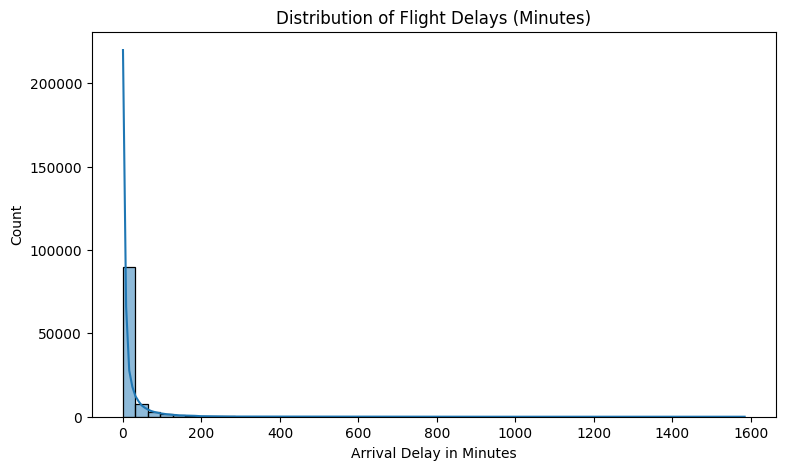

In [7]:
plt.figure(figsize=(30, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_clean['Arrival Delay in Minutes'], bins=50, kde=True)
plt.title('Distribution of Flight Delays (Minutes)')
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Count')


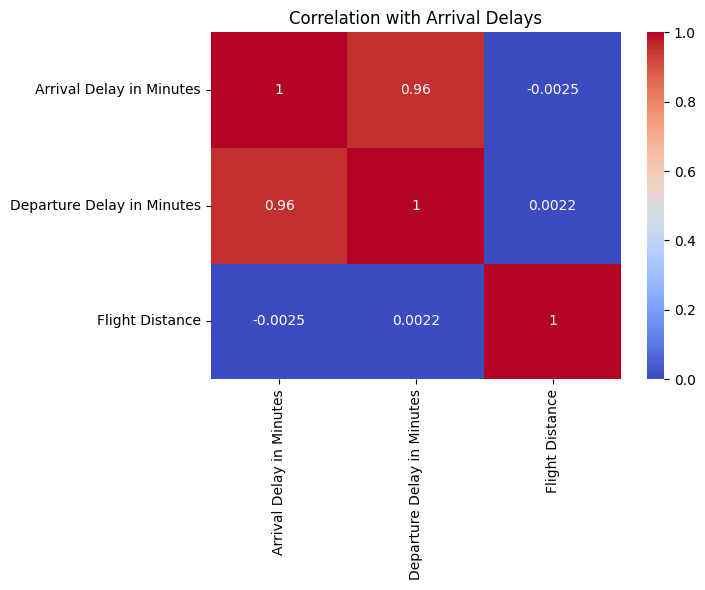

In [8]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 2)
corr_matrix = df_clean[['Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Flight Distance']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation with Arrival Delays')

plt.tight_layout()
plt.show()


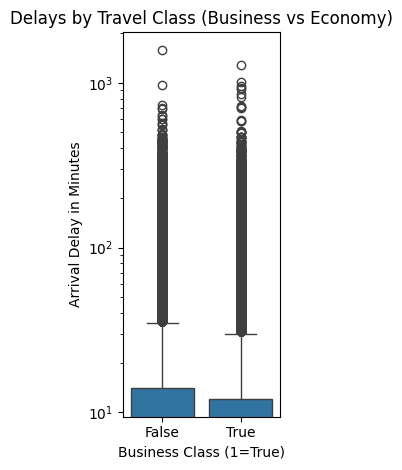

In [9]:
plt.subplot(1, 3, 3)
sns.boxplot(x='Class_Business', y='Arrival Delay in Minutes', data=df_clean)
plt.yscale('log')
plt.title('Delays by Travel Class (Business vs Economy)')
plt.xlabel('Business Class (1=True)')
plt.ylabel('Arrival Delay in Minutes')

plt.tight_layout()
plt.show()

# Outlier in Box PLot

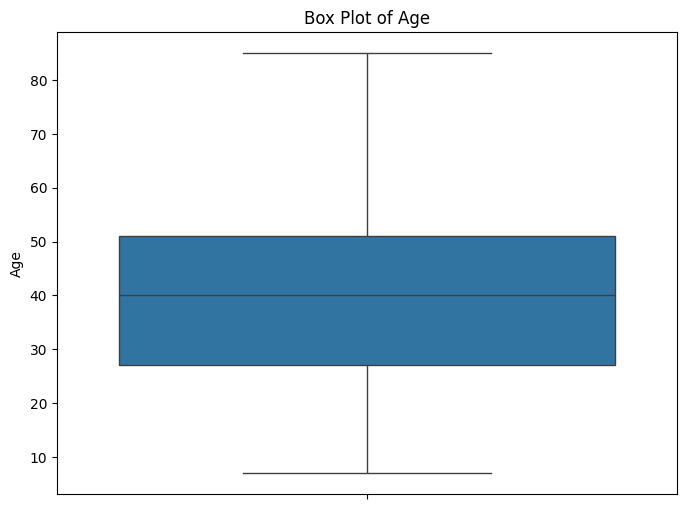

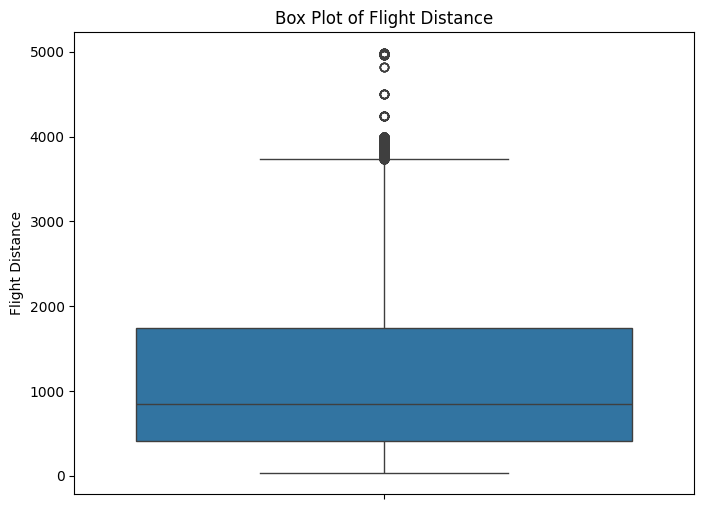

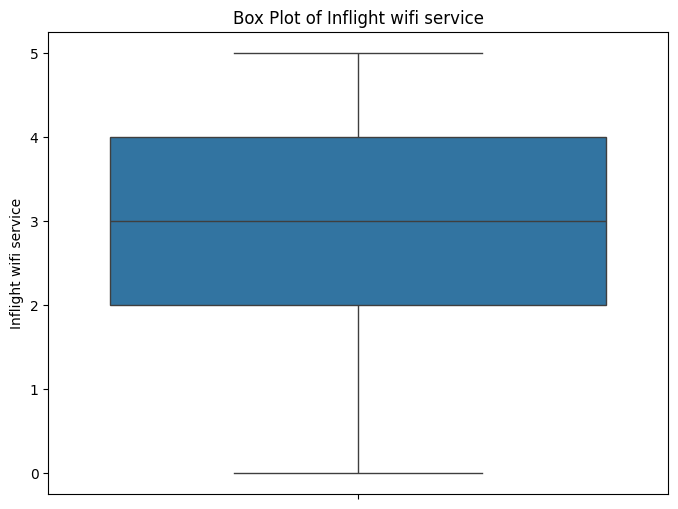

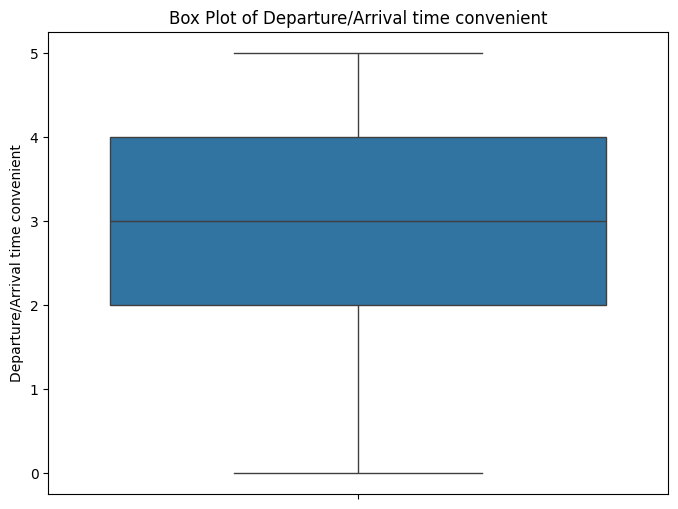

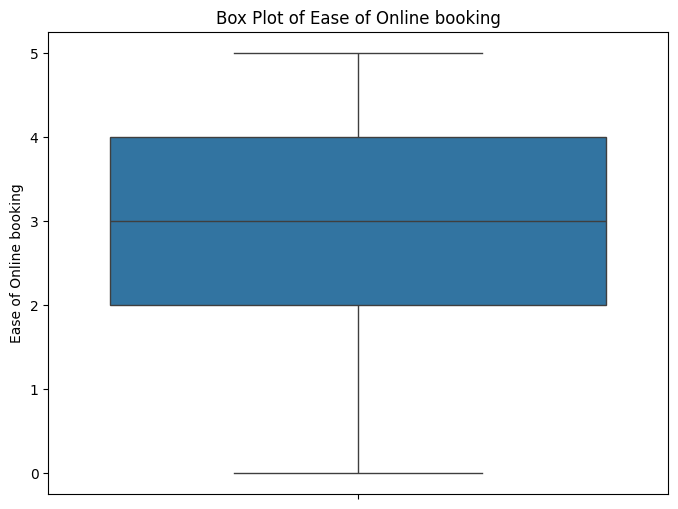

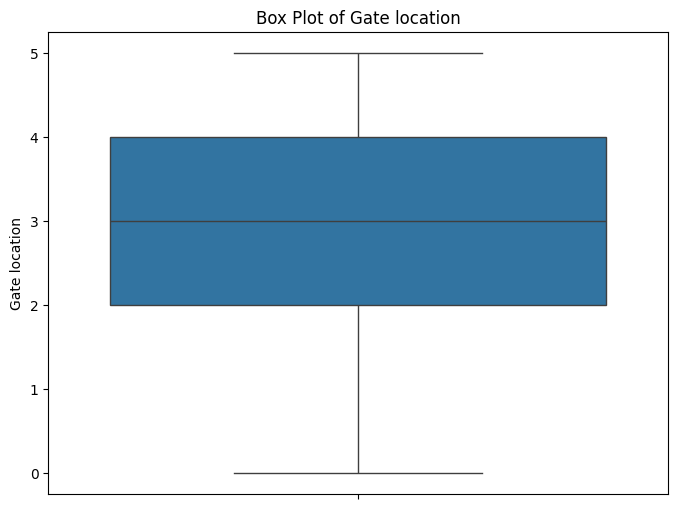

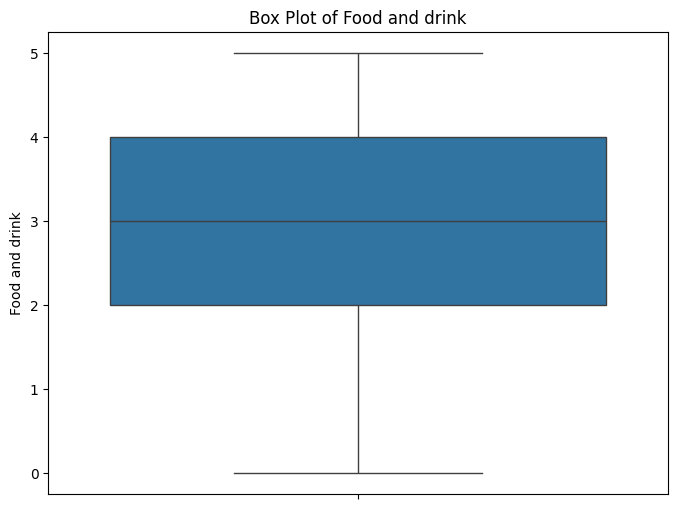

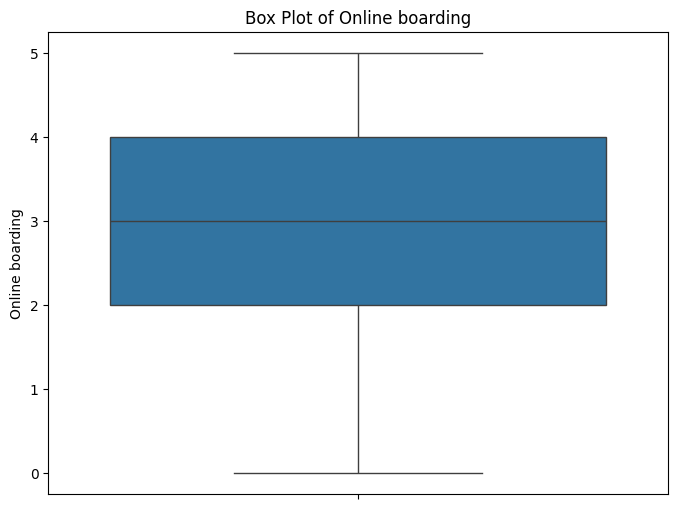

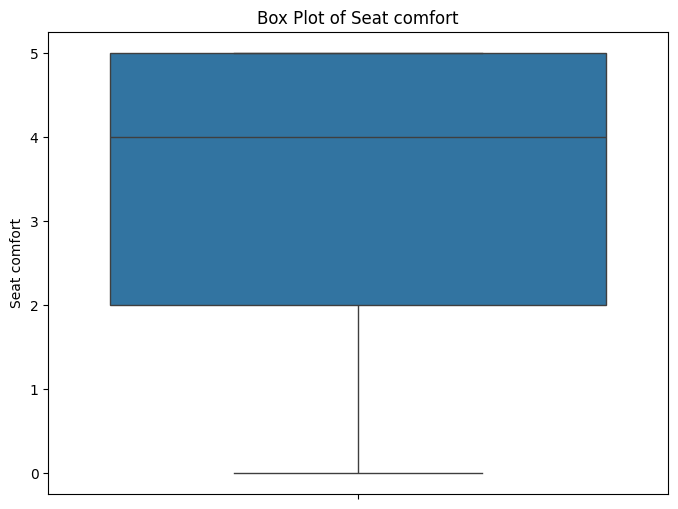

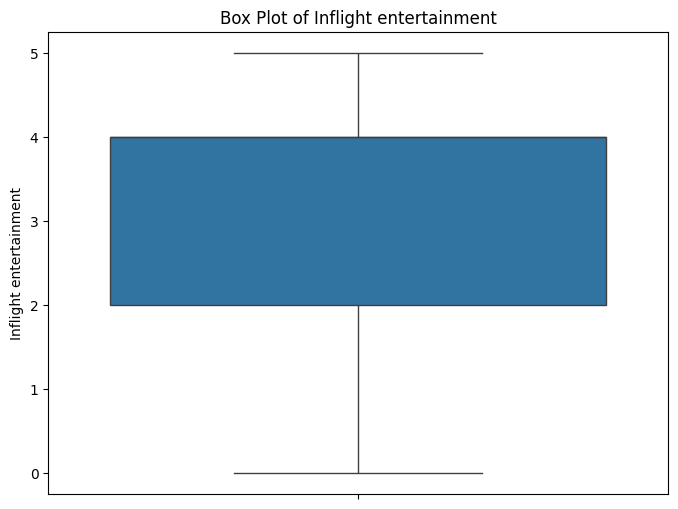

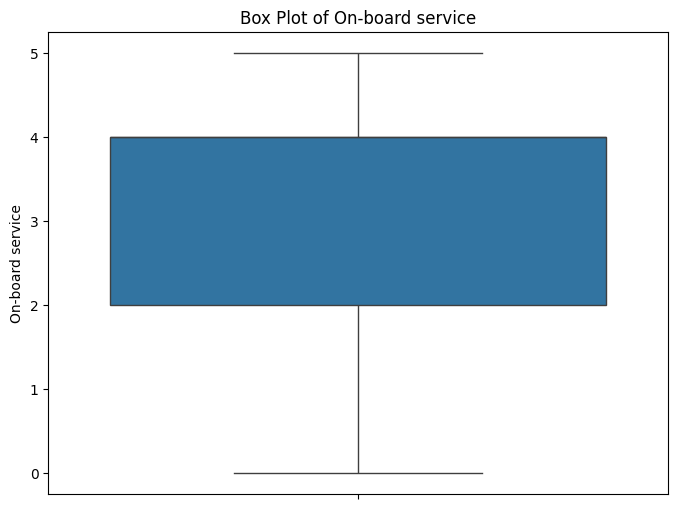

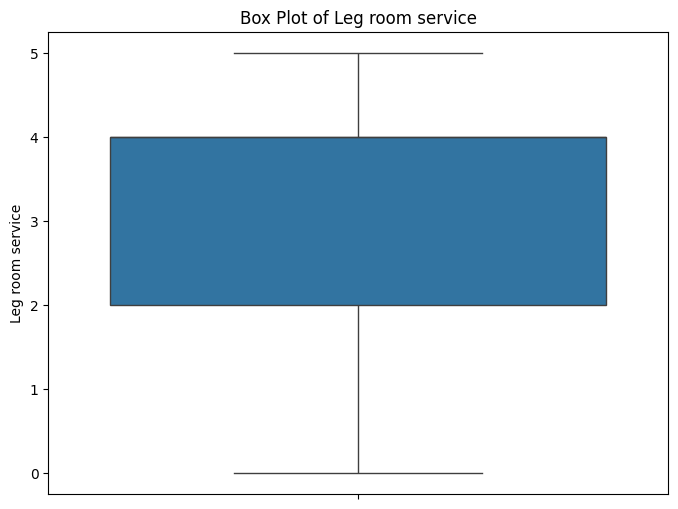

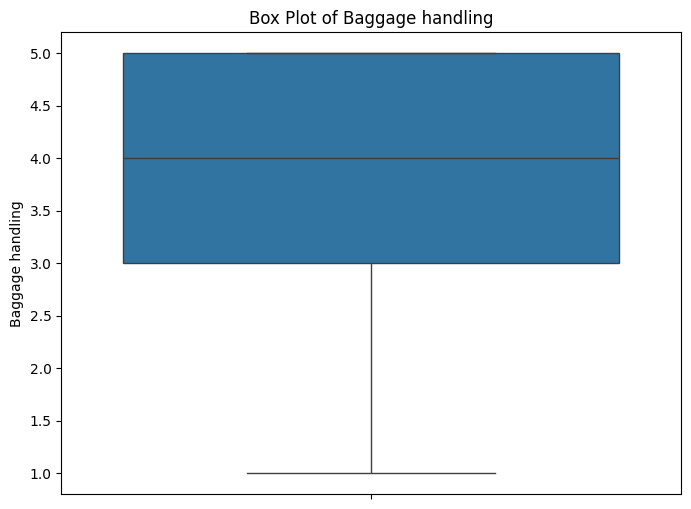

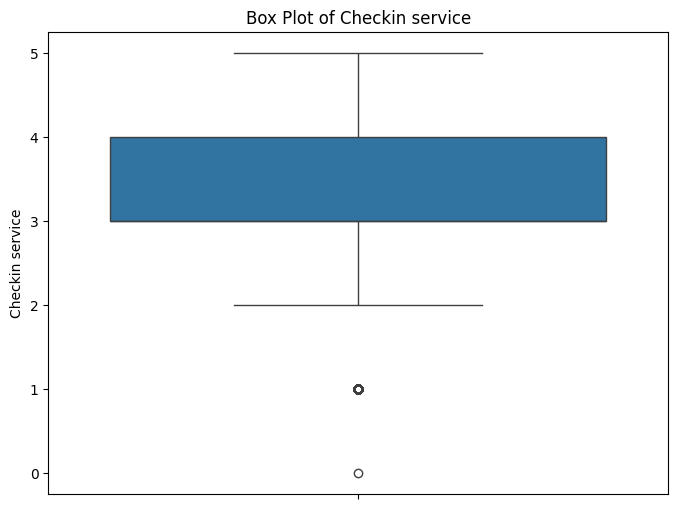

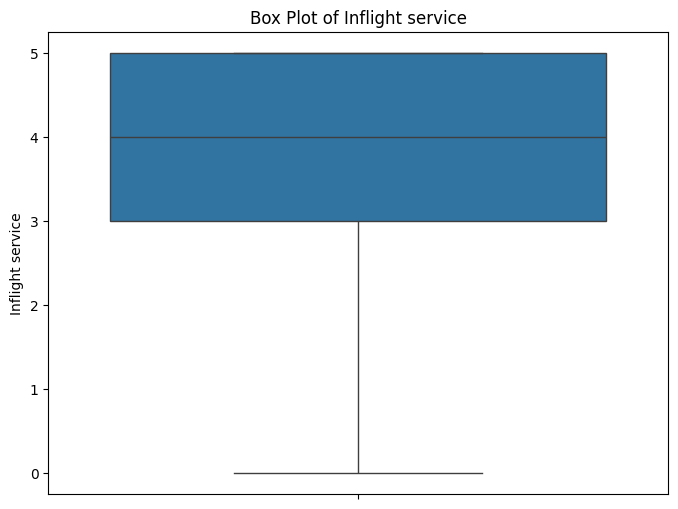

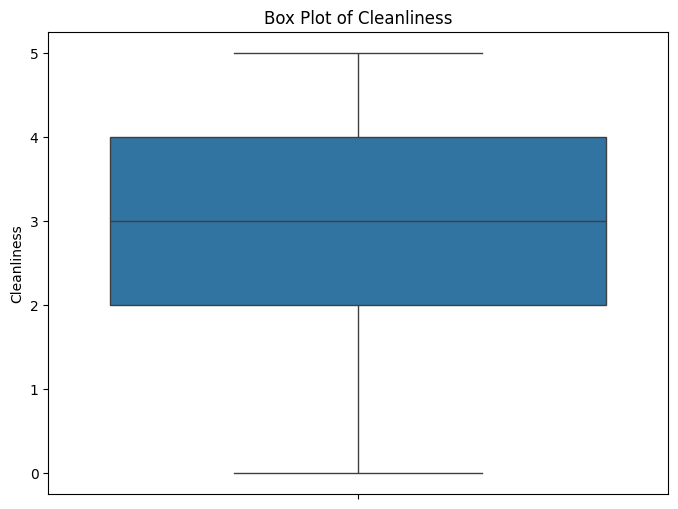

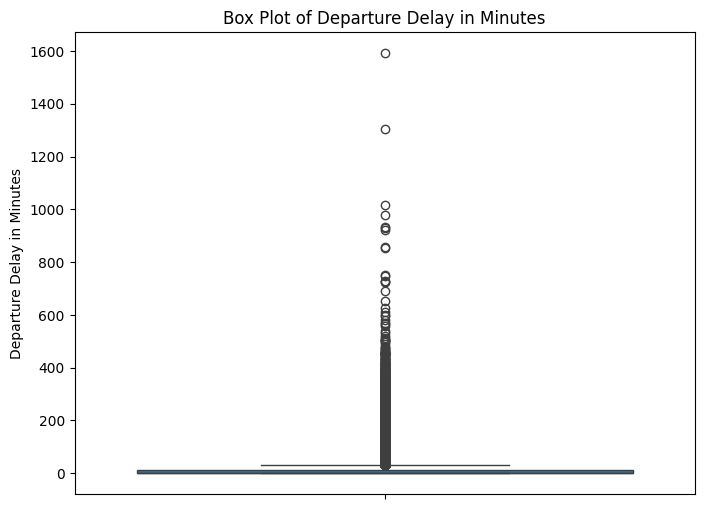

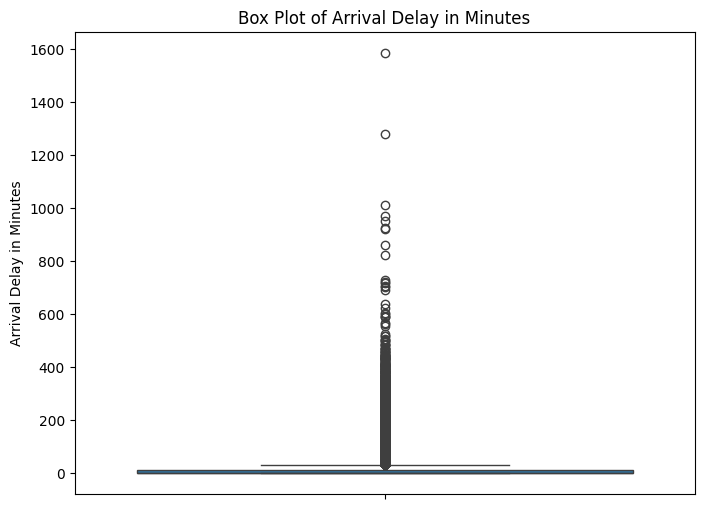

In [10]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

columns_to_exclude = ['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
filtered_cols = [col for col in numeric_cols if col not in columns_to_exclude]

import matplotlib.pyplot as plt
import seaborn as sns

for col in filtered_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()


In [11]:
def detect_outliers(df):
    outlier_counts = {}
    columns_to_exclude = ['Date_Time', 'Vehicle_ID', 'Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                    if col not in columns_to_exclude]

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        num_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        outlier_counts[col] = num_outliers

    return outlier_counts

## Function to normalize outliers greater than the upper bound




In [12]:
def normalize_outliers(df):
    columns_to_exclude = ['Date_Time', 'Vehicle_ID', 'Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                    if col not in columns_to_exclude]

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR

        df.loc[df[col] > upper_bound, col] = upper_bound

    return df

## Function to regularize outliers less than the lower bound

In [13]:
def regularize_outliers(df):
    columns_to_exclude = ['Date_Time', 'Vehicle_ID', 'Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                    if col not in columns_to_exclude]

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR

        df.loc[df[col] < lower_bound, col] = lower_bound

    return df

## Detect outliers BEFORE handling

In [14]:
print("\nOutliers BEFORE Handling:")
outlier_results_before = detect_outliers(df)
for col, count in outlier_results_before.items():
    print(f"{col}: {count} outliers")


Outliers BEFORE Handling:
Unnamed: 0: 0 outliers
id: 0 outliers
Age: 0 outliers
Flight Distance: 2291 outliers
Inflight wifi service: 0 outliers
Departure/Arrival time convenient: 0 outliers
Ease of Online booking: 0 outliers
Gate location: 0 outliers
Food and drink: 0 outliers
Online boarding: 0 outliers
Seat comfort: 0 outliers
Inflight entertainment: 0 outliers
On-board service: 0 outliers
Leg room service: 0 outliers
Baggage handling: 0 outliers
Checkin service: 12891 outliers
Inflight service: 0 outliers
Cleanliness: 0 outliers
Departure Delay in Minutes: 14529 outliers
Arrival Delay in Minutes: 13954 outliers


## Apply normalization & regularization

In [15]:
df = normalize_outliers(df)
df = regularize_outliers(df)

print("\nOutliers AFTER Handling:")
outlier_results_after = detect_outliers(df)
for col, count in outlier_results_after.items():
    print(f"{col}: {count} outliers")

<ipython-input-12-d5034c7bcf1d>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '155854.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] > upper_bound, col] = upper_bound
<ipython-input-12-d5034c7bcf1d>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3736.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] > upper_bound, col] = upper_bound
<ipython-input-12-d5034c7bcf1d>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] > upper_bound, col] = upper_bound
<ipython-input-12-d5034c7bcf1d>:13: FutureWarning: Setting an item o


Outliers AFTER Handling:
Unnamed: 0: 0 outliers
id: 0 outliers
Age: 0 outliers
Flight Distance: 0 outliers
Inflight wifi service: 0 outliers
Departure/Arrival time convenient: 0 outliers
Ease of Online booking: 0 outliers
Gate location: 0 outliers
Food and drink: 0 outliers
Online boarding: 0 outliers
Seat comfort: 0 outliers
Inflight entertainment: 0 outliers
On-board service: 0 outliers
Leg room service: 0 outliers
Baggage handling: 0 outliers
Checkin service: 0 outliers
Inflight service: 0 outliers
Cleanliness: 0 outliers
Departure Delay in Minutes: 0 outliers
Arrival Delay in Minutes: 0 outliers


## After handling Outlier

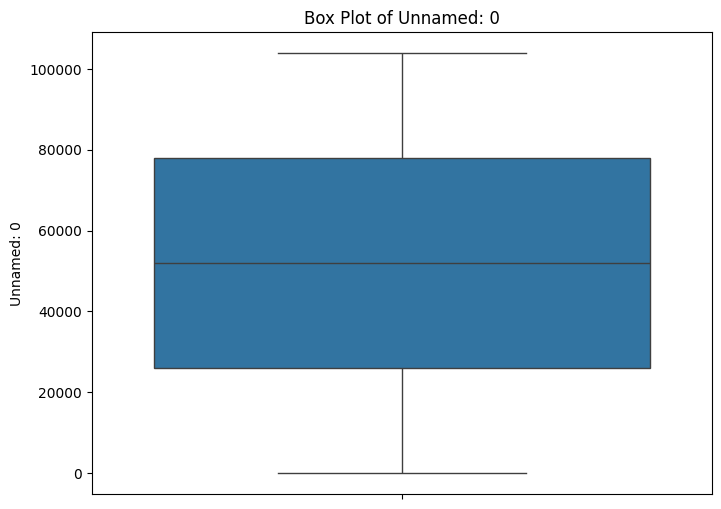

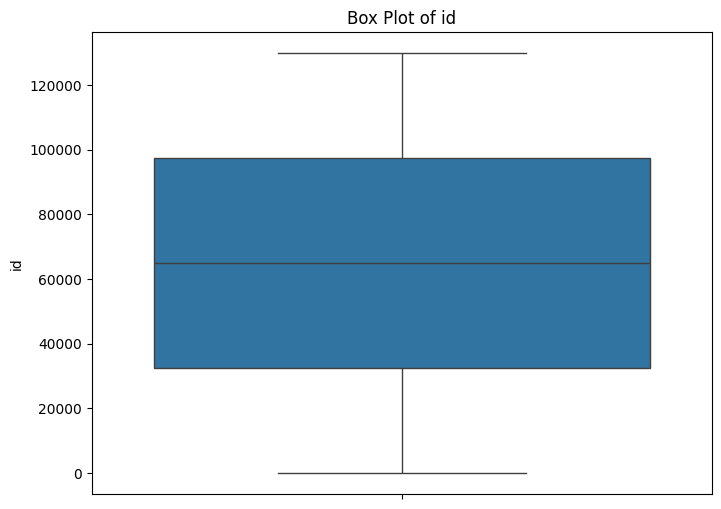

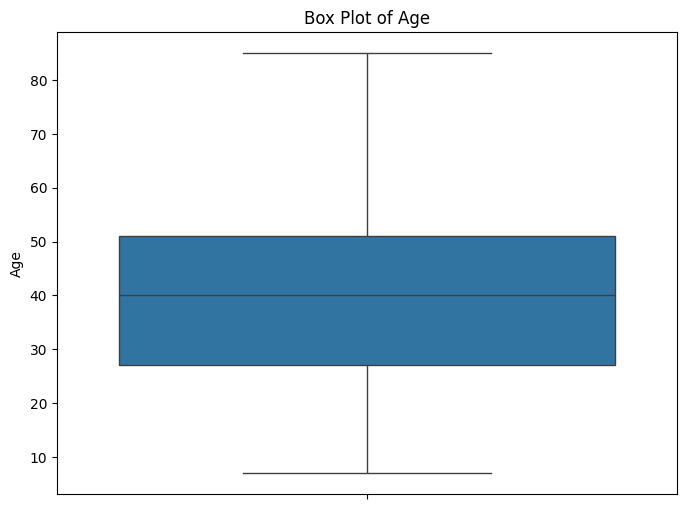

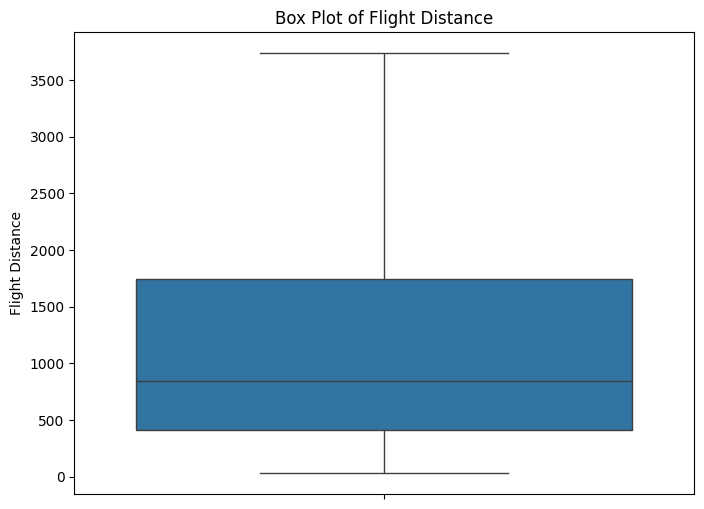

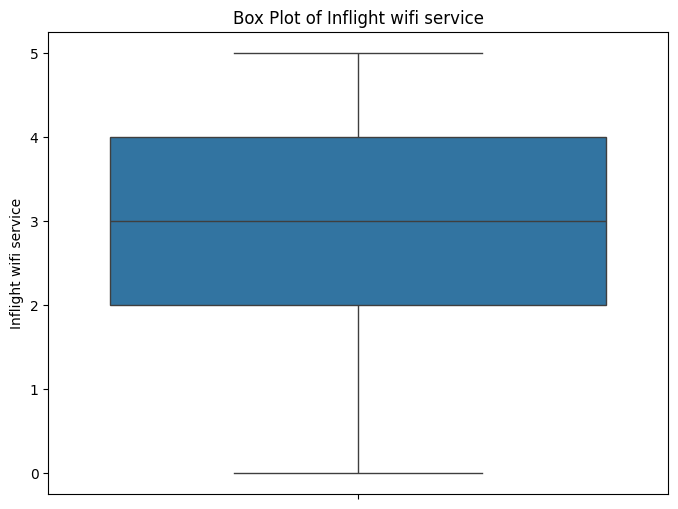

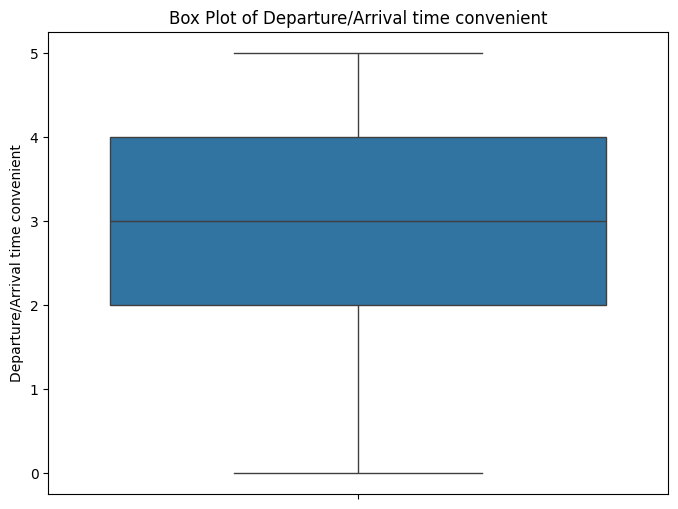

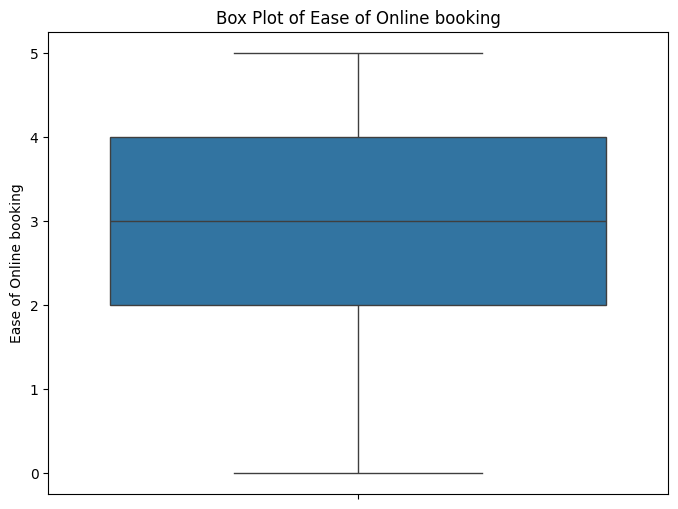

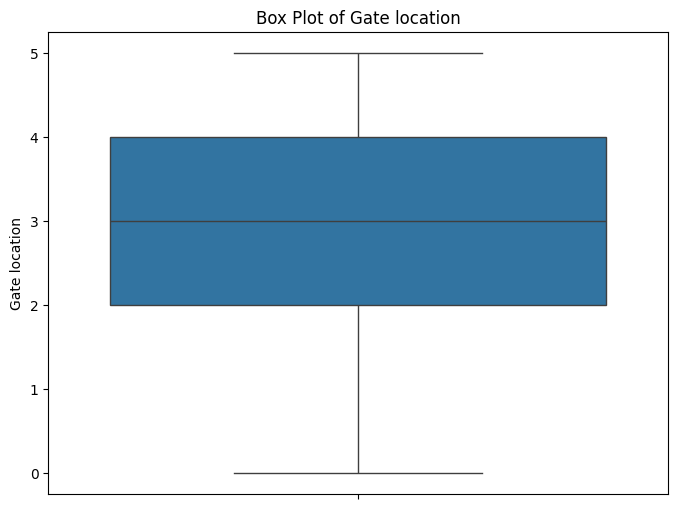

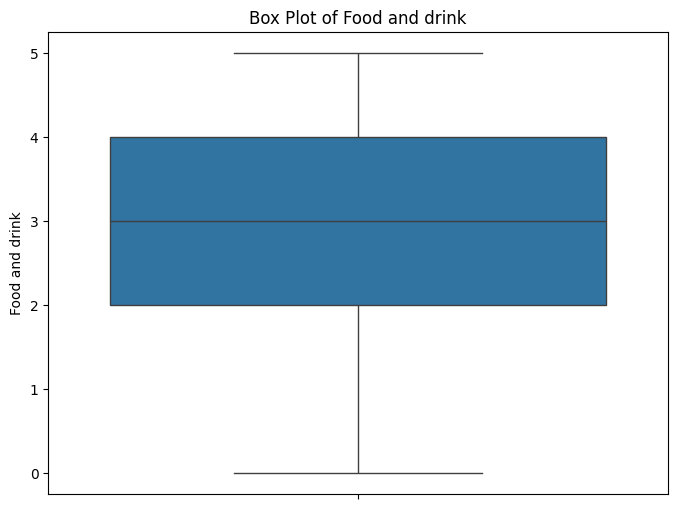

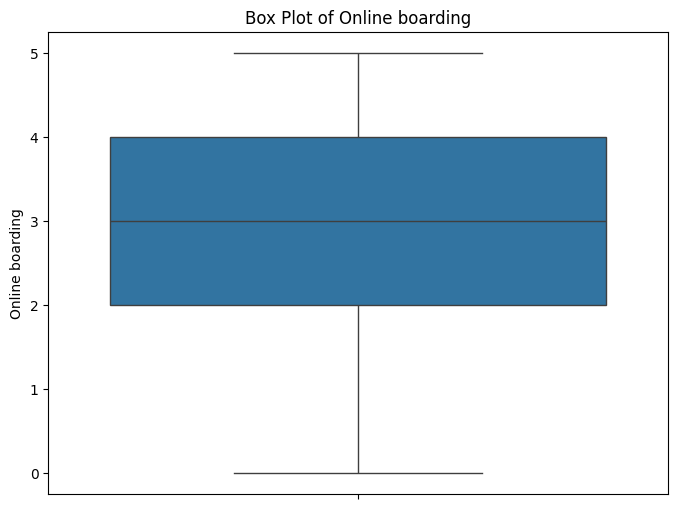

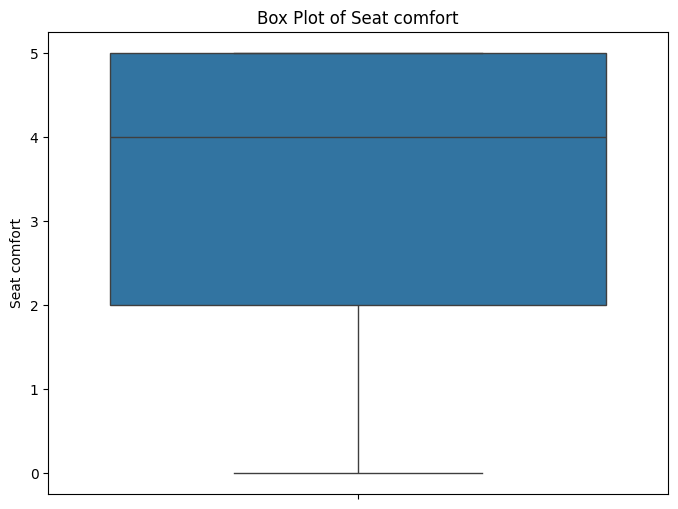

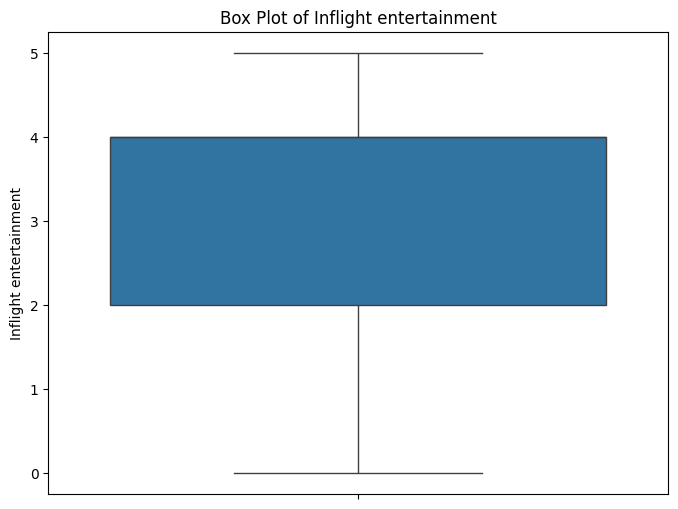

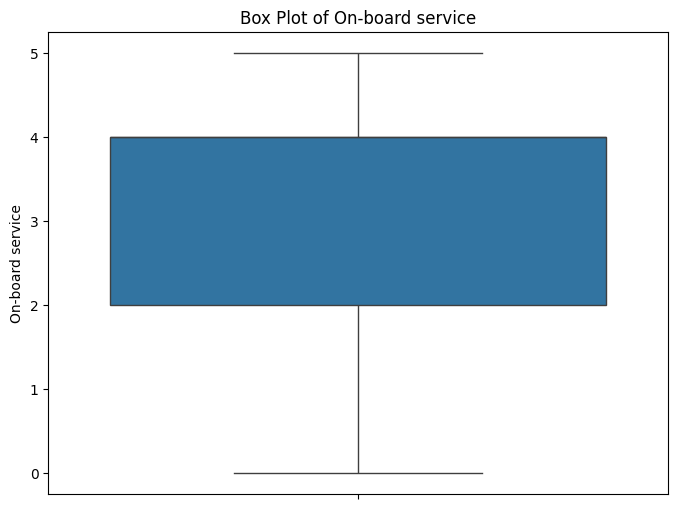

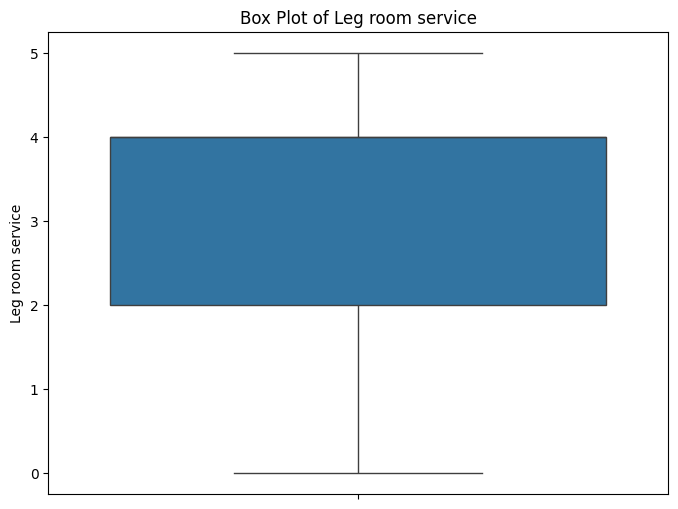

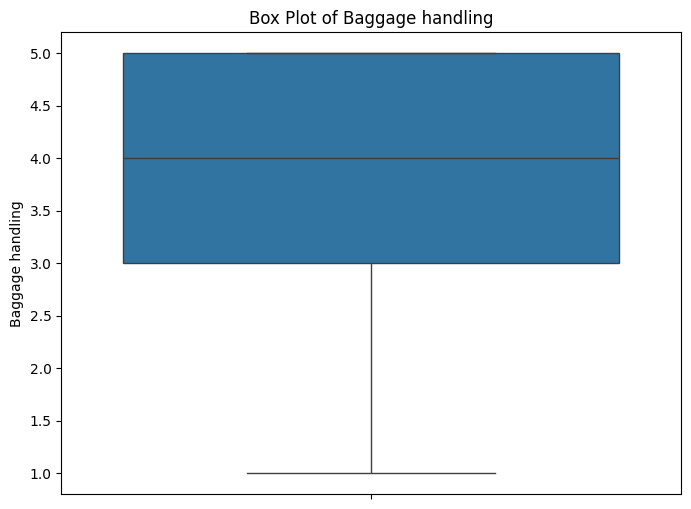

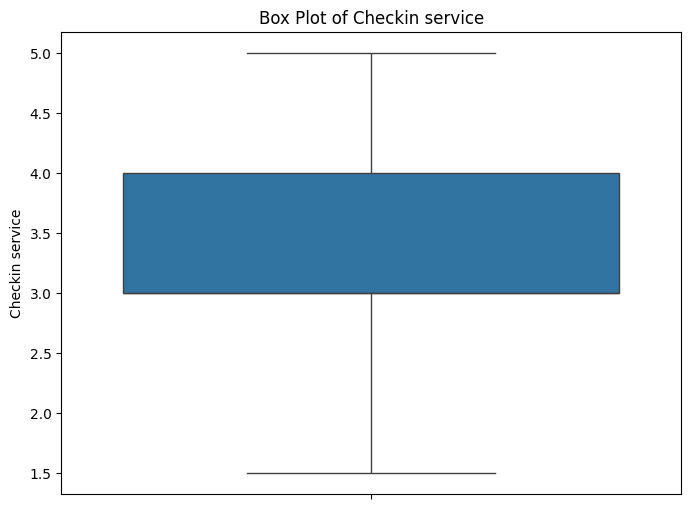

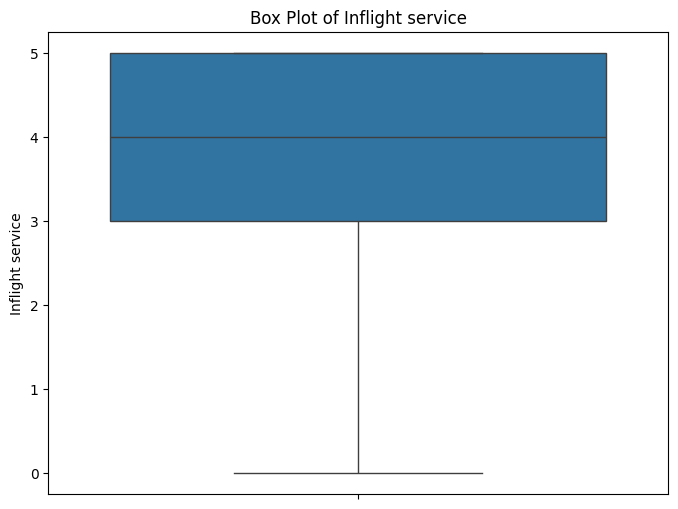

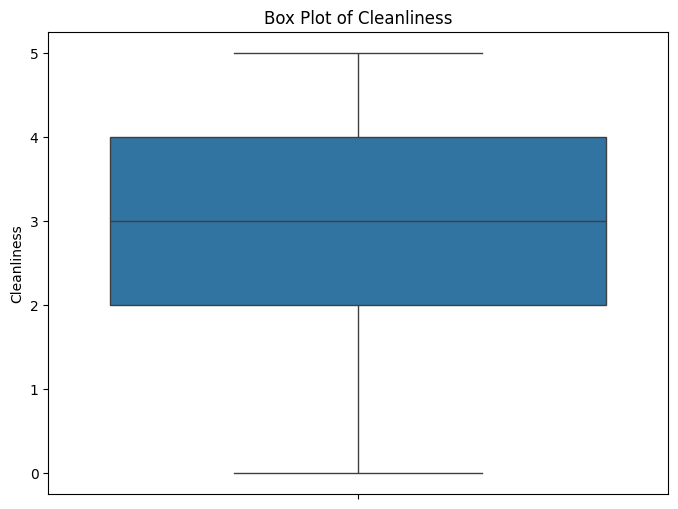

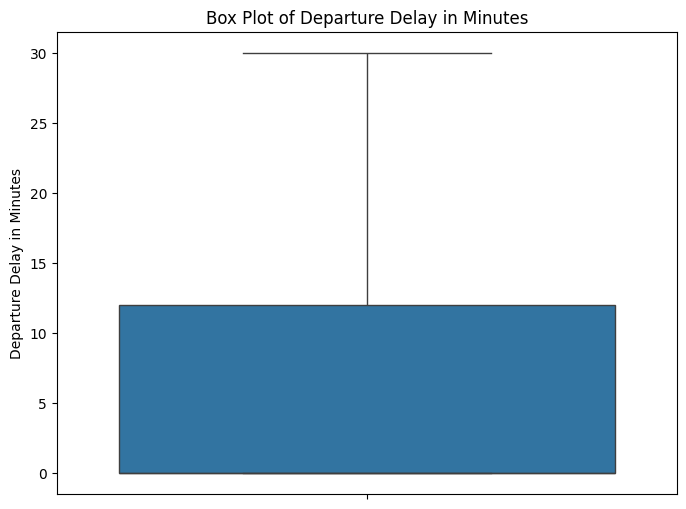

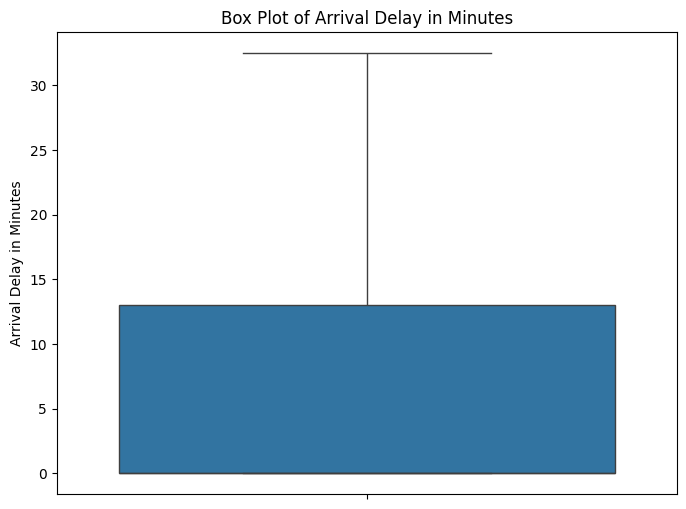

In [16]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

###2. Build linear Regression from scratch

In [17]:
numerical_features = df_clean.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('Arrival Delay in Minutes')
if 'Unnamed: 0' in numerical_features:
    numerical_features.remove('Unnamed: 0')

X = df_clean[numerical_features].values
y = df_clean['Arrival Delay in Minutes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =====================================
# Linear Regression Functions
# =====================================

def initialize_parameters(n_features):
    """Initialize weights and bias for linear regression"""
    weights = np.zeros(n_features)
    bias = 0
    return weights, bias

def compute_gradients(X, y, y_pred):
    """Calculate gradients for linear regression"""
    m = X.shape[0]
    dw = (1/m) * np.dot(X.T, (y_pred - y))
    db = (1/m) * np.sum(y_pred - y)
    return dw, db

def linear_regression_train(X, y, learning_rate=0.01, n_iterations=1000):
    """Main training function for linear regression"""
    weights, bias = initialize_parameters(X.shape[1])
    loss_history = []  # Store loss history for visualization

    for i in range(n_iterations):
        # Forward propagation (prediction)
        y_pred = np.dot(X, weights) + bias

        # Backward propagation (gradient computation)
        dw, db = compute_gradients(X, y, y_pred)

        # Update parameters using gradient descent
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Ensure no NaN values in predictions
        y_pred = np.nan_to_num(y_pred)

        # Calculate and store loss (MSE)
        mse_loss = mean_squared_error(y, y_pred)
        loss_history.append(mse_loss)

        # Print loss every 100 iterations for monitoring
        if i % 100 == 0:
            print(f"Iteration {i}, MSE: {mse_loss:.4f}")

    return weights, bias, loss_history

def linear_regression_predict(X, weights, bias):
    """Make predictions using learned parameters"""
    y_pred = np.dot(X, weights) + bias
    return y_pred

def evaluate_model(X_train, y_train, X_test, y_test, weights, bias):
    """Evaluate the performance on train and test sets"""

    # Predictions for train and test sets
    y_train_pred = linear_regression_predict(X_train, weights, bias)
    y_test_pred = linear_regression_predict(X_test, weights, bias)

    # Calculate evaluation metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    return mse_train, mse_test, r2_train, r2_test, mae_train, mae_test

# =====================================
# Model Training and Evaluation
# =====================================

# Train the model
weights, bias, loss_history = linear_regression_train(X_train, y_train, learning_rate=0.01, n_iterations=1000)

# Evaluate the model
mse_train, mse_test, r2_train, r2_test, mae_train, mae_test = evaluate_model(X_train, y_train, X_test, y_test, weights, bias)

# Display Results
print("\n=== Model Evaluation ===")
print(f"Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")
print(f"Train R²: {r2_train:.4f}, Test R²: {r2_test:.4f}")
print(f"Train MAE: {mae_train:.4f}, Test MAE: {mae_test:.4f}")


Iteration 0, MSE: 1745.5299
Iteration 100, MSE: 328.8431
Iteration 200, MSE: 144.5102
Iteration 300, MSE: 120.2106
Iteration 400, MSE: 116.9350
Iteration 500, MSE: 116.4669
Iteration 600, MSE: 116.3892
Iteration 700, MSE: 116.3718
Iteration 800, MSE: 116.3661
Iteration 900, MSE: 116.3637

=== Model Evaluation ===
Train MSE: 116.3626, Test MSE: 115.9641
Train R²: 0.9232, Test R²: 0.9176
Train MAE: 5.3481, Test MAE: 5.3056


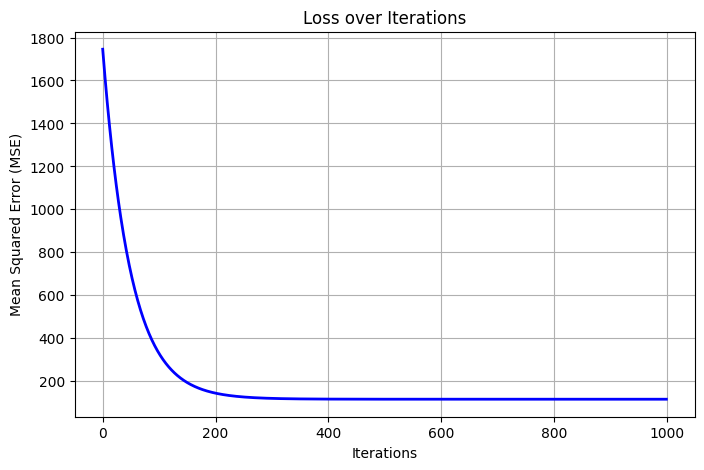

In [18]:
# =====================================
# Visualization of Loss
# =====================================
plt.figure(figsize=(8, 5))
plt.plot(loss_history, color='blue', linewidth=2)
plt.title("Loss over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

###3. Build a Primary Model:

In [19]:
# ============================
# Model 1: Random Forest Regressor
# ============================
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)


In [20]:
# ============================
# Model 2: K-Nearest Neighbors (KNN) Regressor
# ============================
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_train_pred_knn = knn_model.predict(X_train)
y_test_pred_knn = knn_model.predict(X_test)

# Evaluate the KNN model
mse_train_knn = mean_squared_error(y_train, y_train_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
rmse_train_knn = np.sqrt(mse_train_knn)
rmse_test_knn = np.sqrt(mse_test_knn)
mae_train_knn = mean_absolute_error(y_train, y_train_pred_knn)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)
r2_train_knn = r2_score(y_train, y_train_pred_knn)
r2_test_knn = r2_score(y_test, y_test_pred_knn)


In [21]:
# ============================
# Model Evaluation Summary
# ============================
print("=== Model 1: Random Forest Regressor ===")
print(f"Train MSE: {mse_train_rf:.4f}, Test MSE: {mse_test_rf:.4f}")
print(f"Train RMSE: {rmse_train_rf:.4f}, Test RMSE: {rmse_test_rf:.4f}")
print(f"Train MAE: {mae_train_rf:.4f}, Test MAE: {mae_test_rf:.4f}")
print(f"Train R²: {r2_train_rf:.4f}, Test R²: {r2_test_rf:.4f}")

print("\n=== Model 2: K-Nearest Neighbors Regressor ===")
print(f"Train MSE: {mse_train_knn:.4f}, Test MSE: {mse_test_knn:.4f}")
print(f"Train RMSE: {rmse_train_knn:.4f}, Test RMSE: {rmse_test_knn:.4f}")
print(f"Train MAE: {mae_train_knn:.4f}, Test MAE: {mae_test_knn:.4f}")
print(f"Train R²: {r2_train_knn:.4f}, Test R²: {r2_test_knn:.4f}")

=== Model 1: Random Forest Regressor ===
Train MSE: 17.8340, Test MSE: 119.6984
Train RMSE: 4.2230, Test RMSE: 10.9407
Train MAE: 2.2680, Test MAE: 6.0465
Train R²: 0.9882, Test R²: 0.9149

=== Model 2: K-Nearest Neighbors Regressor ===
Train MSE: 141.7459, Test MSE: 213.4526
Train RMSE: 11.9057, Test RMSE: 14.6100
Train MAE: 6.8663, Test MAE: 8.4112
Train R²: 0.9065, Test R²: 0.8483


###4. Hyper-parameter Optimization with Cross-Validation:

In [22]:
# ------------------------------
# Random Forest Hyperparameter Tuning with RandomizedSearchCV
# ------------------------------
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_random_search = RandomizedSearchCV(
    rf, rf_params, n_iter=10, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=2, random_state=42
)
rf_random_search.fit(X_train, y_train)
print("Best Random Forest Parameters:", rf_random_search.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [23]:
# ------------------------------
# K-Nearest Neighbors Hyperparameter Tuning with RandomizedSearchCV
# ------------------------------
knn_params = {
    'n_neighbors': np.arange(3, 15, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'p': [1, 2]
}

knn = KNeighborsRegressor(n_jobs=-1)
knn_random_search = RandomizedSearchCV(
    knn, knn_params, n_iter=10, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=2, random_state=42
)
knn_random_search.fit(X_train, y_train)
print("Best KNN Parameters:", knn_random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best KNN Parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'algorithm': 'auto'}


###5. Feature Selection:

In [24]:

k_best = SelectKBest(score_func=f_regression, k=5)

X_new = k_best.fit_transform(X, y)

feature_scores = k_best.scores_
selected_features = k_best.get_support(indices=True)

selected_feature_names = [numerical_features[i] for i in selected_features]
print("Selected Features: \n", selected_feature_names)
print("Feature Scores: \n", feature_scores[selected_features])

Selected Features: 
 ['Food and drink', 'Inflight entertainment', 'On-board service', 'Inflight service', 'Departure Delay in Minutes']
Feature Scores: 
 [1.09632382e+02 9.73611008e+01 1.28088269e+02 3.62697836e+02
 1.22944828e+06]


###6. Final Model:

In [25]:

selected_features = ['Food and drink', 'Inflight entertainment', 'On-board service', 'Inflight service', 'Departure Delay in Minutes']
X_final = df_clean[selected_features].values
y_final = df_clean['Arrival Delay in Minutes'].values

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Final Model 1: Random Forest Regressor with Optimal Hyperparameters

In [26]:
# ----------------------
# Final Model 1: Random Forest Regressor with Optimal Hyperparameters
# ----------------------
rf_final = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    max_depth=20,
    random_state=42
)
rf_final.fit(X_train_final, y_train_final)

y_train_rf_pred = rf_final.predict(X_train_final)
y_test_rf_pred = rf_final.predict(X_test_final)

# Calculate metrics for Random Forest
mse_train_rf = mean_squared_error(y_train_final, y_train_rf_pred)
mse_test_rf = mean_squared_error(y_test_final, y_test_rf_pred)
rmse_train_rf = np.sqrt(mse_train_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
mae_train_rf = mean_absolute_error(y_train_final, y_train_rf_pred)
mae_test_rf = mean_absolute_error(y_test_final, y_test_rf_pred)
r2_train_rf = r2_score(y_train_final, y_train_rf_pred)
r2_test_rf = r2_score(y_test_final, y_test_rf_pred)

# Final Model 2: K-Nearest Neighbors Regressor with Optimal Hyperparameters

In [27]:
# ----------------------
# Final Model 2: K-Nearest Neighbors Regressor with Optimal Hyperparameters
# ----------------------
knn_final = KNeighborsRegressor(
    weights='uniform',
    p=2,
    n_neighbors=7,
    algorithm='auto'
)
knn_final.fit(X_train_final, y_train_final)

# Predictions
y_train_knn_pred = knn_final.predict(X_train_final)
y_test_knn_pred = knn_final.predict(X_test_final)

# Calculate metrics for KNN
mse_train_knn = mean_squared_error(y_train_final, y_train_knn_pred)
mse_test_knn = mean_squared_error(y_test_final, y_test_knn_pred)
rmse_train_knn = np.sqrt(mse_train_knn)
rmse_test_knn = np.sqrt(mse_test_knn)
mae_train_knn = mean_absolute_error(y_train_final, y_train_knn_pred)
mae_test_knn = mean_absolute_error(y_test_final, y_test_knn_pred)
r2_train_knn = r2_score(y_train_final, y_train_knn_pred)
r2_test_knn = r2_score(y_test_final, y_test_knn_pred)

# Output the results for both models

In [28]:
# Output the results for both models
print("=== Final Model 1: Random Forest Regressor ===")
print(f"Train MSE: {mse_train_rf:.4f}, Test MSE: {mse_test_rf:.4f}")
print(f"Train RMSE: {rmse_train_rf:.4f}, Test RMSE: {rmse_test_rf:.4f}")
print(f"Train MAE: {mae_train_rf:.4f}, Test MAE: {mae_test_rf:.4f}")
print(f"Train R²: {r2_train_rf:.4f}, Test R²: {r2_test_rf:.4f}")
print("\n=== Final Model 2: K-Nearest Neighbors Regressor ===")
print(f"Train MSE: {mse_train_knn:.4f}, Test MSE: {mse_test_knn:.4f}")
print(f"Train RMSE: {rmse_train_knn:.4f}, Test RMSE: {rmse_test_knn:.4f}")
print(f"Train MAE: {mae_train_knn:.4f}, Test MAE: {mae_test_knn:.4f}")
print(f"Train R²: {r2_train_knn:.4f}, Test R²: {r2_test_knn:.4f}")

=== Final Model 1: Random Forest Regressor ===
Train MSE: 81.6511, Test MSE: 122.9322
Train RMSE: 9.0361, Test RMSE: 11.0875
Train MAE: 4.9902, Test MAE: 5.8198
Train R²: 0.9461, Test R²: 0.9126

=== Final Model 2: K-Nearest Neighbors Regressor ===
Train MSE: 107.6652, Test MSE: 126.3050
Train RMSE: 10.3762, Test RMSE: 11.2386
Train MAE: 5.5654, Test MAE: 5.9702
Train R²: 0.9290, Test R²: 0.9102


In [29]:
best_model = "Random Forest Regressor" if r2_test_rf > r2_test_knn else "K-Nearest Neighbors Regressor"
print(f"Best performing model: {best_model}")


Best performing model: Random Forest Regressor


###7. Conclusion :

# **Conclusion**

## **1. Model Performance**
We evaluated **Random Forest Regressor** and **K-Nearest Neighbors (KNN) Regressor** to predict **Arrival Delay in Minutes**. The performance comparison reveals:

- **Test MSE**:  
  - Random Forest: `122.93`  
  - KNN: `126.30`  
- **Test RMSE**:  
  - Random Forest: `11.08`  
  - KNN: `11.23`  
- **Test R²**:  
  - Random Forest: `0.9126`  
  - KNN: `0.9102`

### **Key Takeaways**:
- **Random Forest** outperforms **KNN** across all metrics, especially in larger datasets.
- **KNN** struggles with high-dimensional data and higher computational costs.

---

## **2. Impact of Methods**
### **Hyperparameter Tuning**:
Using **RandomizedSearchCV**, we optimized both models' parameters:
- **Best Random Forest Params**: `n_estimators=100`, `max_depth=20`
- **Best KNN Params**: `n_neighbors=7`, `weights='uniform'`

### **Feature Selection**:
- Top features selected via **SelectKBest**:  
  - **Departure Delay**, **Inflight Service**, **Food and Drink**  
- This significantly reduced dimensionality, improving efficiency.

---

## **3. Insights & Future Directions**
### **Insights**:
- **Departure delays** are the strongest predictor of **arrival delays**.
- **Random Forest** handles large datasets better, proving to be more robust.

### **Future Work**:
- Test models like **XGBoost**, **Gradient Boosting**, and **Neural Networks**.
- Explore advanced techniques like **Recursive Feature Elimination (RFE)** or **SHAP values**.

---

## **Final Recommendation**:
- **Random Forest Regressor** is the best choice due to its higher accuracy, generalization, and scalability.
- **KNN** is less efficient, especially with large datasets.

---

### This study highlights the significance of feature selection, hyperparameter tuning, and model comparison in building accurate flight delay prediction models. ✈️
